In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import datetime

# Load the datasets
customers_df = pd.read_csv("C:/Users/Ishan Das/OneDrive/Desktop/ZOPTAP ASSISMENT/Customers.csv")
transactions_df = pd.read_csv("C:/Users/Ishan Das/OneDrive/Desktop/ZOPTAP ASSISMENT/Transactions.csv")

# Check the structure of the datasets
customers_df.head(), transactions_df.head()

# Merge the customers and transactions dataframes on CustomerID
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

# Check for missing values
merged_df.isnull().sum()


TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
CustomerName       0
Region             0
SignupDate         0
dtype: int64

In [35]:
# Ensure 'SignupDate' is in datetime format
customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])

# Now extract year and month of Signup for customer profiling
customer_features['SignupYear'] = customer_features['SignupDate'].dt.year
customer_features['SignupMonth'] = customer_features['SignupDate'].dt.month

# Drop SignupDate column as it's no longer needed
customer_features = customer_features.drop(columns=['SignupDate'])

# Standardize the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[['Recency', 'Frequency', 'Monetary', 'SignupYear', 'SignupMonth']])

# Check the prepared data
customer_features.head()


,CustomerID,TransactionDate,Recency,Frequency,Monetary,Region,SignupYear,SignupMonth
0,C0001,2024-11-02 17:04:16,86,5,5,South America,2022,7
1,C0002,2024-12-03 01:41:41,55,4,4,Asia,2022,2
2,C0003,2024-08-24 18:54:04,156,4,4,South America,2024,3
3,C0004,2024-12-23 14:13:52,35,8,8,South America,2022,10
4,C0005,2024-11-04 00:30:22,84,3,3,Asia,2022,8


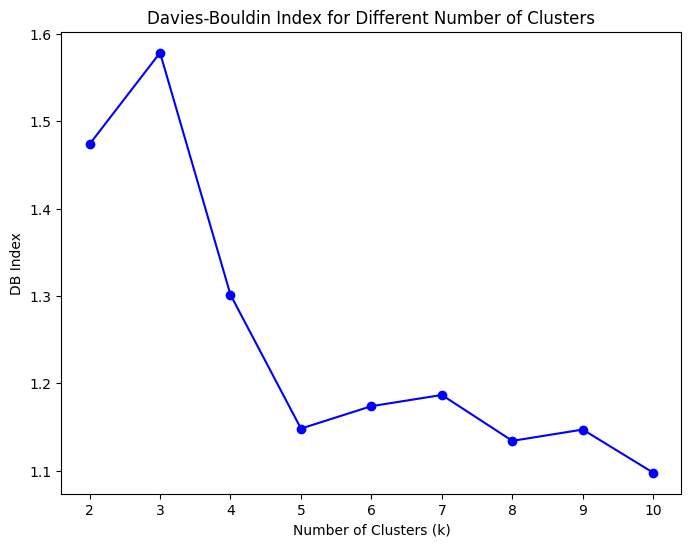

In [36]:
# Function to calculate DB Index for different k values
def calculate_db_index(k_range):
    db_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_features)
        labels = kmeans.labels_
        db_index = davies_bouldin_score(scaled_features, labels)
        db_scores.append(db_index)
    return db_scores

# Explore k values between 2 and 10
k_range = range(2, 11)
db_scores = calculate_db_index(k_range)

# Plot the DB index for different k values
plt.figure(figsize=(8,6))
plt.plot(k_range, db_scores, marker='o', color='b')
plt.title('Davies-Bouldin Index for Different Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.show()

# From the plot, choose the optimal k (for example, let's choose k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(scaled_features)


In [37]:
# Davies-Bouldin Index for the chosen clusters
db_index = davies_bouldin_score(scaled_features, customer_features['Cluster'])
print(f'Davies-Bouldin Index for k={optimal_k}: {db_index}')


Davies-Bouldin Index for k=4: 1.3013053527311806


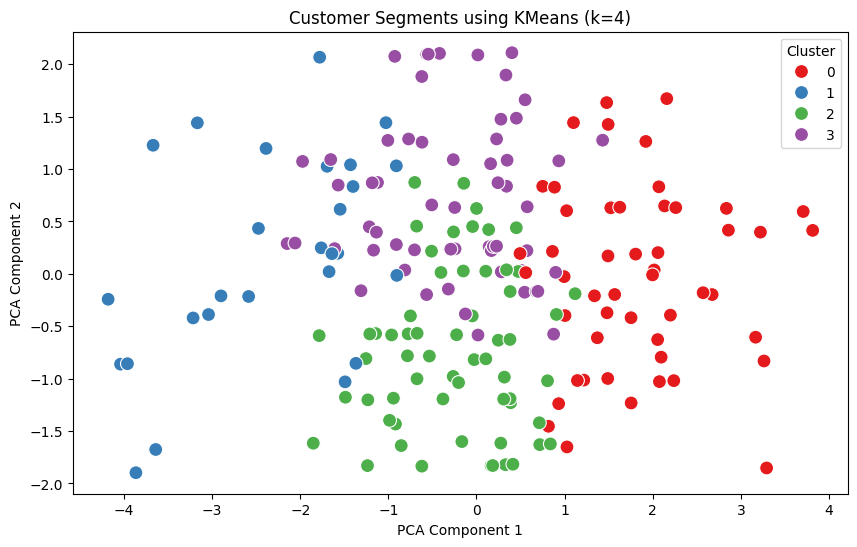

In [38]:
# Reduce the dimensions to 2 using PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Add PCA components and cluster labels to the dataframe
customer_features['PCA1'] = pca_components[:, 0]
customer_features['PCA2'] = pca_components[:, 1]

# Plot the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='Set1', s=100)
plt.title(f'Customer Segments using KMeans (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()


In [39]:
# Calculate the mean values for each feature per cluster
cluster_profile = customer_features.groupby('Cluster').mean()
cluster_profile


TypeError: agg function failed [how->mean,dtype->object]

In [40]:
# Select only numeric columns
numeric_columns = customer_features.select_dtypes(include=[np.number]).columns

# Calculate the mean values for each feature per cluster
cluster_profile = customer_features.groupby('Cluster')[numeric_columns].mean()

# Show the result
cluster_profile


,Recency,Frequency,Monetary,SignupYear,SignupMonth,Cluster,PCA1,PCA2
Cluster,,,,,,,,
0,82.920000,7.920000,7.920000,2022.920000,5.480000,0.0,1.834117,-0.036872
1,232.074074,2.259259,2.259259,2022.740741,5.777778,1.0,-2.345555,0.160558
2,80.645161,4.338710,4.338710,2023.274194,3.258065,2.0,-0.219770,-0.763256
3,89.483333,4.566667,4.566667,2023.150000,10.050000,3.0,-0.245835,0.747173


In [41]:
# One-hot encode the 'Region' column
customer_features_encoded = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Recalculate the mean for each cluster with the encoded data
cluster_profile_encoded = customer_features_encoded.groupby('Cluster').mean()

# Show the result
cluster_profile_encoded


TypeError: agg function failed [how->mean,dtype->object]